# Improving Trading Strategies with HMM
Trend following as an investment strategy has been around for ages. Invest in an asset (i.e. SPY) when it trades above its 200-day simple moving price average, else stay out. This remarkably simple rule tends to dramatically reduce risk associated with just a buy-and-hold strategy. 

Trend-following can be effective for various reasons:

1. It taps into the well-known momentum effect: assets that recently performed well will continue to do so.
2. It employs a form of risk management by staying out of the asset when it's trending downward, potentially reducing further losses.

However, it’s no silver bullet. When there is no recession or consistent downtrend, the strategy is typically not fast enough to re-invest and could trail behind the classic buy-and-hold. We could partially alleviate this problem by using different moving averages based on e.g. market volatility. Somewhat similar to what they did in this fast and slow momentum system. However, this would cause us to end up with more arbitrary hyper-parameters for the investing strategy, risking overfitting (overfitting?).

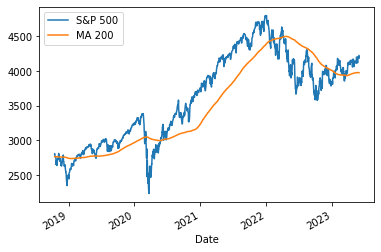

In [1]:
from datetime import datetime
import pandas as pd
import yfinance as yf

sp500 = yf.download('^GSPC','2018-01-01',datetime.today(), progress=False)['Close'].rename('S&P 500')
ma_200 = sp500.rolling(window=200).mean().rename('MA 200')
data = pd.concat([sp500, ma_200], axis=1).dropna()
data.plot();

### Hidden Markov Models

In [7]:
from hmmlearn import hmm

sp500_returns = sp500.pct_change().dropna()
model = hmm.GaussianHMM(n_components=2)
model.fit(sp500_returns.values.reshape(-1, 1))

GaussianHMM(n_components=2)

In [11]:
predictions = model.predict(sp500_returns.values.reshape(-1, 1))
pd.unique(predictions)

array([0, 1])

#### Investigate the states

In [18]:
print('Means')
print('State 1: {:.2%}'.format(model.means_[0][0]))
print('State 2: {:.2%}'.format(model.means_[1][0]))

Means
State 1: 0.13%
State 2: -0.43%


#### Plot results

<AxesSubplot:xlabel='Date'>

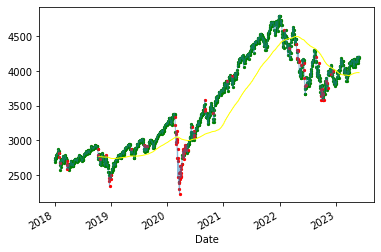

In [37]:
import matplotlib.pyplot as plt

sp500.plot(linewidth=1, alpha=0.5);
# plot the states
# bull state
bullx, bully = [], []
bearx, beary = [], []
for i in range(len(sp500[1:])):
    if predictions[i] == 0:
        bullx.append(sp500.index[i])
        bully.append(sp500[i])
    else:
        bearx.append(sp500.index[i])
        beary.append(sp500[i])
        
plt.scatter(bullx, bully, color='green',s=5)
plt.scatter(bearx, beary, color='red', s=5)
ma_200.plot(linewidth=1, color='yellow')

In [41]:
def evaluate_ma200_strat(prices):
    initial_investment = 100
    prices = prices.rename('price')
    ma_200 = prices.rolling(window=200).mean().rename('MA 200')
    data = pd.concat([prices, ma_200], axis=1).dropna()
    data['long'] = data['MA 200'] < data['price']
    data['return'] = data['price'].pct_change()
    data.loc[~data['long'], 'return'] = 0
    data.dropna(inplace=True)
    final_investment = initial_investment
    for r in data['return']:
        final_investment *= r + 1
    return final_investment/100

def evaluate_hmm_strat(prices, predictions):
    initial_investment = 100
    data = pd.DataFrame({'price': prices[1:]})
    data['long'] = predictions == 0
    data['return'] = data['price'].pct_change()
    data.loc[~data['long'], 'return'] = 0
    data.dropna(inplace=True)
    final_investment = initial_investment
    for r in data['return']:
        final_investment *= r + 1
    return final_investment/100

print('MA 200')
print('------')
final_investment = evaluate_ma200_strat(sp500)
print('Final value: {:.2%}'.format(round(final_investment, 4)))

print('\n\nHMM')
print('---')
final_investment = evaluate_hmm_strat(sp500, predictions)
print('Final value: {:.2%}'.format(round(final_investment, 4)))

MA 200
------
Final value: 260.45%


HMM
---
Final value: 485.31%
